### LONG SHORT TERM MEMORY NEURAL NETWORK

##### REQUIRED LIBRARIES

In [20]:
# Import required libraries
from tqdm import tqdm_notebook,tqdm
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
import numpy
import os
import platform

##### REQUIRED FUNCTIONS

In [2]:
def load_bergen_data(years = ['2013','2014','2015','2016','2017'], mkt='Bergen'):
    """
    load_bergen_data function
    
    This function extracts annual datasets of hourly electricity price (source North Pool).
    It loads only Bergen
    
    Args:
        1) years -> list of dataset to be included in trainset and validationset
        2) mkt -> which spot price of the North Pool is going to be predicted
    Out:
        1) hourly electricity price dataset of the selected region
    """
    file_name_1 = 'elspot-prices_'
    file_name_2 = '_hourly_dkk.csv'
    if platform.system()=='Linux':
        data_folder = os.getcwd().replace('notebook','data/')
    else:
        data_folder = os.getcwd().replace('notebook','data\\')
    
    all_data=[]
    for year in years:
        file_name_tot = data_folder + file_name_1 + year + file_name_2
        all_data.append(pd.read_csv(file_name_tot,encoding = "ISO-8859-1",sep=';',decimal=','))
    df = pd.concat(all_data, ignore_index=True,sort= True)
    df = df[['datetime','Hours',mkt]]
    return df

In [3]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    #df = df.dropna()
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history.iloc[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def split_features_label(dataset):
    features, label = dataset[:, 0:-1], dataset[:, -1]
    features = features.reshape(features.shape[0], 1, features.shape[1])
    return features,label

# fit an LSTM network to training data
def fit_lstm(train, val, batch_size, nb_epoch, neurons):
    X, y = split_features_label(train)
    X_val, y_val = split_features_label(val)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in tqdm_notebook(range(nb_epoch),leave=False):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(X_val,y_val))
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


### LSTM MODEL

In [27]:
# model parameters
n_features = 24 # how many time steps to consider for the analysis
time_interval = 1 # how many hour in advance the modell should make the prediction

# internal paramters for the LSTM model
n_shift = n_features + time_interval - 1
n_ahead = range(0,time_interval)

In [28]:
# data loading and feature extraction
df = load_bergen_data()
raw_values = df['Bergen'].dropna()
diff_values = difference(raw_values, interval = time_interval)
supervised = timeseries_to_supervised(diff_values, n_shift)
supervised_values = supervised.values

In [29]:
# train - validation split
validation_share = 0.20
test_size = round(validation_share*supervised_values.shape[0])
train_size = supervised_values.shape[0]-test_size
train, test = supervised_values[0:train_size,:], supervised_values[train_size:,:]
if len(n_ahead)>0:
    train, test = np.delete(train, n_ahead, axis = 1),np.delete(test, n_ahead, axis = 1)

In [30]:
# feature scaling
scaler, train_scaled, test_scaled = scale(train, test)

In [31]:
# Ensemble of models
n_ensemble = 1
lstm_ensemble = list()

In [32]:
# fit the model

for n in tqdm_notebook(range(n_ensemble)):
    lstm_model = fit_lstm(train_scaled,test_scaled, 1, 5, 4)
    lstm_ensemble.append(lstm_model)
    lstm_model = []

# forecast the entire training dataset to build up state for forecasting


#### MODEL PERFORMANCE 

In [33]:
def make_predictions(lstm_model,test_scaled):
    # walk-forward validation on the test data
    predictions = list() 
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    return predictions

In [34]:
def evaluate_model_performance(lstm_ensemble, test_scaled = test_scaled, raw_values = raw_values):
    rmse_ensemble = list()
    mae_ensemble = list()
    predictions_ensemble = list()
    test_samples = test_scaled.shape[0]
    for i in tqdm_notebook(range(len(lstm_ensemble))):
        predictions = make_predictions(lstm_ensemble[i],test_scaled)
        predictions_ensemble.append(predictions)
        rmse = sqrt(mean_squared_error(raw_values[-test_samples:], predictions))
        rmse_ensemble.append(rmse)
        mae = mean_absolute_error(raw_values[-test_samples:], predictions)
        mae_ensemble.append(mae)
    return rmse_ensemble, mae_ensemble, predictions_ensemble    

In [35]:
rmse_ensemble, mae_ensemble, predictions_ensemble = evaluate_model_performance(lstm_ensemble, test_scaled = test_scaled, raw_values = raw_values)

In [36]:
print(np.std(np.array(rmse_ensemble)))
print(np.mean(np.array(rmse_ensemble)))
print(np.std(np.array(mae_ensemble)))
print(np.mean(np.array(mae_ensemble)))

0.0
10.009562520109947
0.0
4.016653607834865


In [37]:
# line plot of observed vs predicted
def plot_sample_preditions(predictions_ensemble,n_model=0,n_day=5):
    
    subset= 24*n_day
    model_predictions = predictions_ensemble[n_model]
    
    plt.figure(figsize=(15,7))
    plt.title('Model results on validation set')
    plt.xlabel('Time [Hours]')
    plt.ylabel('Electricity Price [DKK]')
    plt.plot(range(subset),raw_values[-subset:],color = 'b')
    plt.plot(range(subset),model_predictions[-subset:], color = 'r')
    plt.legend()
    plt.show()
    return

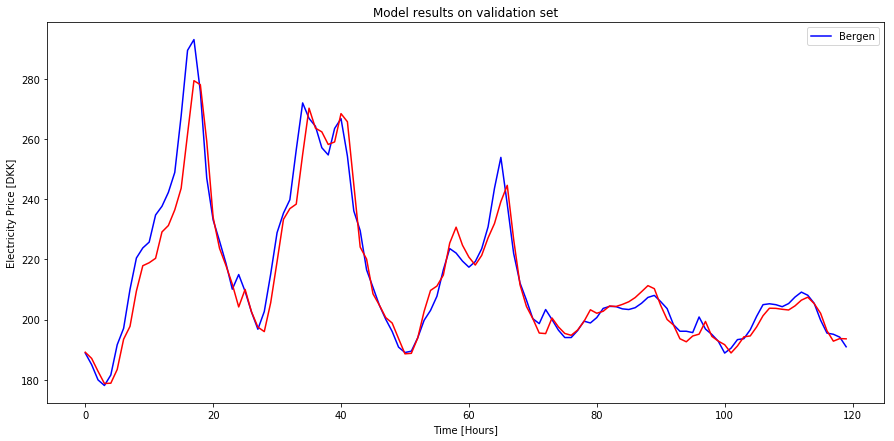

In [38]:
plot_sample_preditions(predictions_ensemble)